## SPC Experiments for Input CT Slice Monitoring

### Imports

In [1]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from scipy.spatial import distance
from sklearn.metrics import confusion_matrix

In [2]:
sns.set_style('darkgrid')
np.random.seed(2023)
random.seed(2023)

In [3]:
import sys
sys.path.append("../SPC_Charts")
from feature_loader import load_and_divide_features
from similarity_computation import compute_similarity
import CUSUM_detector

### Computing feature similarities
__Note__: Analysis is done for best feature extraction method and metrics. Here, we identifed this to be _contrastive ResNet18 features_ scored by _cosine similarity_.

In [4]:
"""Load dataset"""
D = np.load("../numpy_files/data_splits.npz")
Xtr = D["Xtr"]
ytr = D["ytr"]
Xvl = D["Xvl"]
yvl = D["yvl"]
Xtt = D["Xtt"]
ytt = D["ytt"]

In [5]:
"""Load best (by sensitivity / specificity / accuracy) features"""
train_features, all_test_features, test_in_dist_features, test_out_dist_features = load_and_divide_features('ctr', ytr, ytt)

In [6]:
"""Compute metric scores based on best metric"""
cosine_train_similarities = compute_similarity(train_features, train_features, "cosine")
cosine_mean_train = cosine_train_similarities["mean"]
cosine_std_train = cosine_train_similarities["std"]
cosine_3UCL_train_upper = cosine_mean_train + 3 * cosine_std_train
cosine_3LCL_train_lower = cosine_mean_train - 3 * cosine_std_train
print("MEAN train: {} | STD train: {}".format(cosine_mean_train, cosine_std_train))

# Compute cosine similarity statistics for in-control or in-distribution test features
cosine_in_dist_similarities = compute_similarity(train_features, test_in_dist_features, "cosine")
cosine_mean_in_dist = cosine_in_dist_similarities["mean"]
cosine_std_in_dist = cosine_in_dist_similarities["std"]
print("MEAN in_dist_test: {} | STD in_dist_test: {}".format(cosine_mean_in_dist, cosine_std_in_dist))

# Compute cosine similarity statistics for out-of-distribution test features
cosine_out_dist_similarities = compute_similarity(train_features, test_out_dist_features, "cosine")
cosine_mean_out_dist = cosine_out_dist_similarities["mean"]
cosine_std_out_dist = cosine_out_dist_similarities["mean"]
print("MEAN out_dist_test: {} | STD out_dist_test: {}".format(cosine_mean_out_dist, cosine_std_out_dist))

MEAN train: 0.938915442541879 | STD train: 0.059848087310906455
MEAN in_dist_test: 0.8782172408325826 | STD in_dist_test: 0.14702639304996368
MEAN out_dist_test: 0.3107355484915329 | STD out_dist_test: 0.3107355484915329


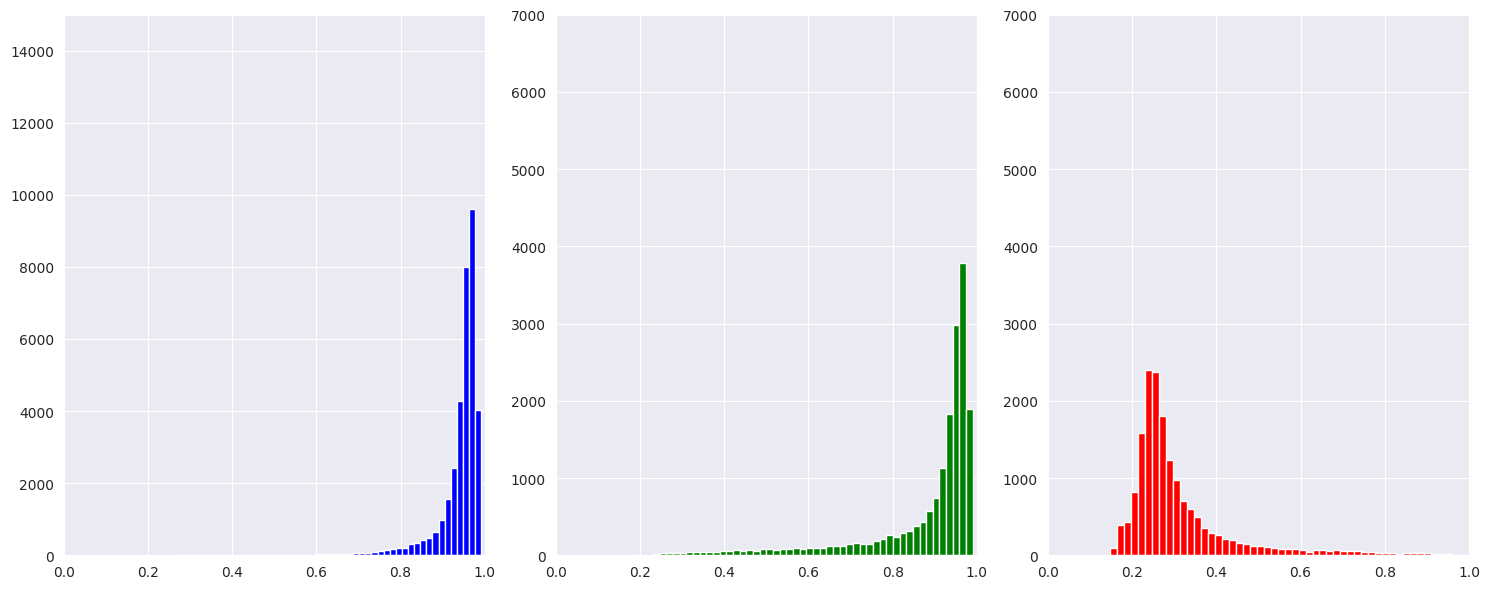

In [7]:
"""Feature similarity score distributions"""
fig, ax = plt.subplots(1, 3, figsize=(15,6))
ax[0].hist(cosine_train_similarities['similarities'], bins=50, color="blue")
ax[1].hist(cosine_in_dist_similarities['similarities'], bins=50, color="green")
ax[2].hist(cosine_out_dist_similarities['similarities'], bins=50, color="red")
ax[0].set_xlim([0,1])
ax[1].set_xlim([0,1])
ax[2].set_xlim([0,1])
# hand-chosen limits based on # of bins
ax[0].set_ylim([0,15000])
ax[1].set_ylim([0,7000])
ax[2].set_ylim([0,7000])
plt.tight_layout()
plt.savefig("../figs/feature_similarity_dists.png")
plt.show()

### Three-sigma SPC Chart for a Testing Subset

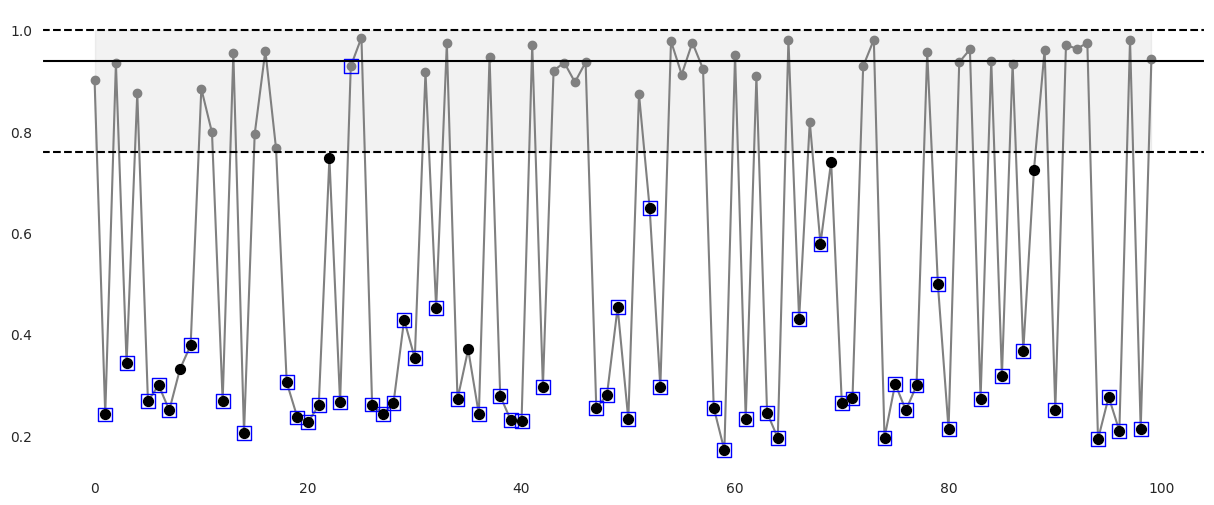

In [8]:
"""Three-sigma SPC chart for a subset (n=100) of the test set using training control limits"""
n=100
sample = np.random.randint(low=0, high=ytt.shape[0], size=n)
scores = compute_similarity(train_features, all_test_features[sample, :], "cosine")["similarities"]
ood_labels = 1 - ytt[sample]
# for cosine similarity, only need to check if image is lesser than LCL similarity limit
ood_predictions = [1 if val < cosine_3LCL_train_lower else 0 for val in scores]

# Plot the SPC chart
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(scores, marker='o', linestyle='-', color='grey', zorder=1)

# Plot control limits and mean
ax.axhline(np.clip(cosine_3UCL_train_upper, a_min=0.0, a_max=1.0), color='k', linestyle='--', label='Upper Control Limit (UCL)')  # Black color for UCL
ax.axhline(np.clip(cosine_3LCL_train_lower, a_min=0.0, a_max=1.0), color='k', linestyle='--', label='Lower Control Limit (LCL)')  # Black color for LCL
ax.axhline(cosine_mean_train, color='k', linestyle='-', label='Mean')  # Black color for mean
plt.fill_between(range(n), \
                    np.clip(cosine_3LCL_train_lower, a_min=0.0, a_max=1.0), \
                    np.clip(cosine_3UCL_train_upper, a_min=0.0, a_max=1.0), \
                    color='grey', alpha=0.1)

# Highlight points outside of control limits with pink circle around them
for i, val in enumerate(scores):
    if ood_predictions[i] == 1:
        ax.scatter(i, val, color='black', marker='o', s=50, zorder=2)  # pink filled-in circles aroud points that violate control limits

# Blue square around points that are in-fact OOD
for i, val in enumerate(scores):
    if ood_labels[i] == 1:
        ax.scatter(i, val, marker='s', facecolor='none', edgecolors='blue', s=100)

ax.set_facecolor('white')  # White background
# ax.set_xlabel('Image Sequence')
# ax.set_ylabel('Cosine Similarity ')
# ax.set_ylim([0.5,1])
# ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)  # Lighter grid lines for better visibility

# Show the plot
plt.savefig("../figs/ood_ctr_cosine.png")
plt.show()

In [9]:
# Calculate accuracy, sensitivity, specificity on this plotted subset
cfm = confusion_matrix(ood_labels, ood_predictions)
tn, fp, fn, tp = cfm.ravel()
acc = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"Accuracy: {acc:.4f} | Specificity: {specificity:.4f} | Sensitivity: {sensitivity:.4f}")

Accuracy: 0.9400 | Specificity: 0.8889 | Sensitivity: 0.9818


### Simulated Monitoring Scenario

In [10]:
"""Time simulation
Days 0-30: 0-1% error rate (uniformly random)
Days 30-60: 3-5% error rate (uniformly random)
"""
# Define the number of days and images per day
total_days = 60
images_per_day = 100

# Create an empty list to store daily data
all_data = []
percentages_out_dist = []

# Function to select data for each day
def select_daily_data(in_dist_data, out_dist_data, out_dist_percent, day_data_count):
    out_dist_count = int(day_data_count * out_dist_percent / 100)
    in_dist_count = day_data_count - out_dist_count

    # Randomly select out-of-distribution and in-distribution data
    daily_out_dist_data = np.random.choice(out_dist_data, out_dist_count, replace=False)
    daily_in_dist_data = np.random.choice(in_dist_data, in_dist_count, replace=False)

    # Combine and return the daily data
    return np.concatenate([daily_out_dist_data, daily_in_dist_data])

 # Simulate data for each day
for day in range(1, total_days + 1):
    if day <= 30:
        percent_out_dist = (0, 1)
    else:
        percent_out_dist = (3,5)

    # If range is given for percent, choose randomly
    if type(percent_out_dist) == tuple:
        p = np.random.uniform(low=percent_out_dist[0], high=percent_out_dist[1])
    else:
        p = percent_out_dist
    percentages_out_dist.append(p)

    daily_data = select_daily_data(
        cosine_in_dist_similarities["similarities"],
        cosine_out_dist_similarities["similarities"],
        p,
        images_per_day
    )
    all_data.append(daily_data)


# Combine all daily data for CUSUM analysis
avg_cusum_data = np.concatenate(all_data)
daily_averages = [np.mean(day) for day in all_data]
CUSUM_data_average_day = np.array(daily_averages)

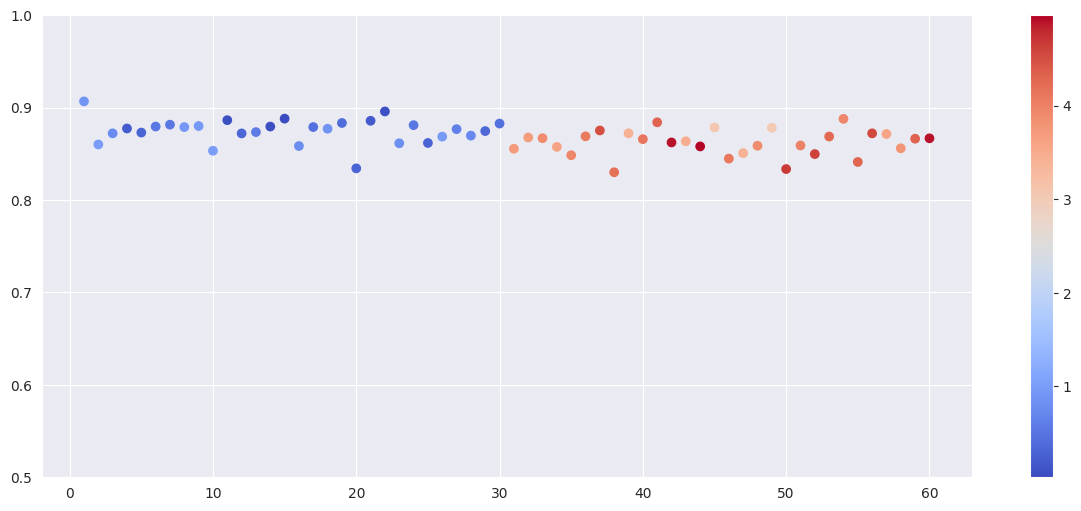

In [11]:
"""Plotting day-averaged cosine distance"""
plt.figure(figsize=(15, 6))
sc = plt.scatter(range(1, total_days + 1), daily_averages, c=percentages_out_dist, cmap='coolwarm')
# plt.colorbar(sc, label='Out-of-Distribution Percentage (%)')
plt.colorbar(sc)
# plt.title('Day-Averaged Cosine Similarity')
# plt.xlabel('Day')
# plt.ylabel('Average Cosine Distance')
plt.ylim([0.5, 1])
plt.grid(True)
plt.savefig("../figs/ood_simulation.png")
plt.show()

In [12]:
# Save the cosine similarity for each batch for each day.
# np.savetxt("../numpy_files/per_day_cosine_CUSUM.csv", daily_averages, delimiter=",", fmt='%s')

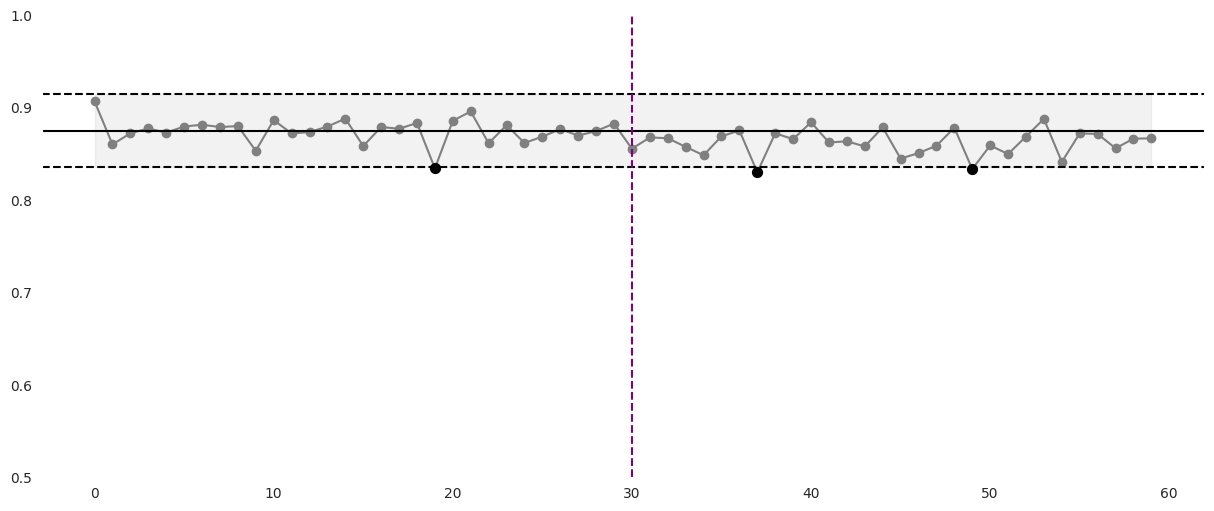

In [13]:
"""Three-sigma SPC chart for per-day averages"""
# Define the control limits using the three-sigma rule
mean = np.mean(daily_averages[:30])
upper_control_limit = np.mean(daily_averages[:30]) + 3 * np.std(daily_averages[:30])
lower_control_limit = np.mean(daily_averages[:30]) - 3 * np.std(daily_averages[:30])

shift_start_day = 30

# Plot the SPC chart
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(daily_averages, marker='o', linestyle='-', color='grey', label='Daily Averages', zorder=2)

# Plot control limits and mean
ax.axhline(np.clip(upper_control_limit, a_min=0.0, a_max=1.0), color='k', linestyle='--', label='Upper Control Limit (UCL)')  # Black color for UCL
ax.axhline(np.clip(lower_control_limit, a_min=0.0, a_max=1.0), color='k', linestyle='--', label='Lower Control Limit (LCL)')  # Black color for LCL
ax.axhline(mean, color='k', linestyle='-', label='Mean')  # Black color for mean
plt.fill_between(range(len(daily_averages)), \
                    np.clip(lower_control_limit, a_min=0.0, a_max=1.0), \
                    np.clip(upper_control_limit, a_min=0.0, a_max=1.0), \
                    color='grey', alpha=0.1)

# Highlight points outside of control limits with pink circle around them
for i, val in enumerate(daily_averages):
    if val < lower_control_limit:
        ax.scatter(i, val, facecolors='black', marker='o', s=50, zorder=3)  # Pink filled-in circles aroud points that violate control limits

# Indicate the first shift point
ax.axvline(x=shift_start_day, color='purple', linestyle='--', label='Induced Shift')  # Purple line for shift start

ax.set_facecolor('white')  # White background
# ax.set_xlabel('Time (Day)')
# ax.set_ylabel('Average Cosine Similarity ')
ax.set_ylim([0.5,1])
# ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)  # Lighter grid lines for better visibility

# Show the plot
plt.savefig("../figs/batched_3sigma_ctr_cosine.png")

In [14]:
"""CUSUM"""
# Specify the control parameters and the threshold
pre_change_days = 30  # Number of days the process is in-control
total_days = 60  # Total number of days in the dataset
control_limit = 4  # Multiplier for control limit
detector = CUSUM_detector.CUSUMChangeDetector(pre_change_days, total_days)

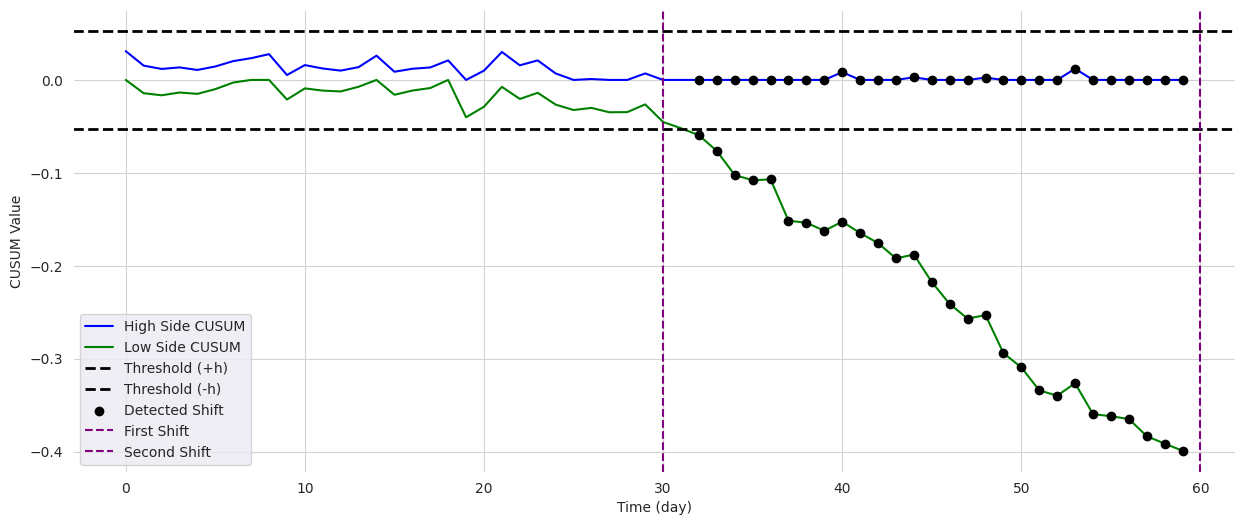

/home/kesavan.venkatesh/.conda/envs/P3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kesavan.venkatesh/.conda/envs/P3.8/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


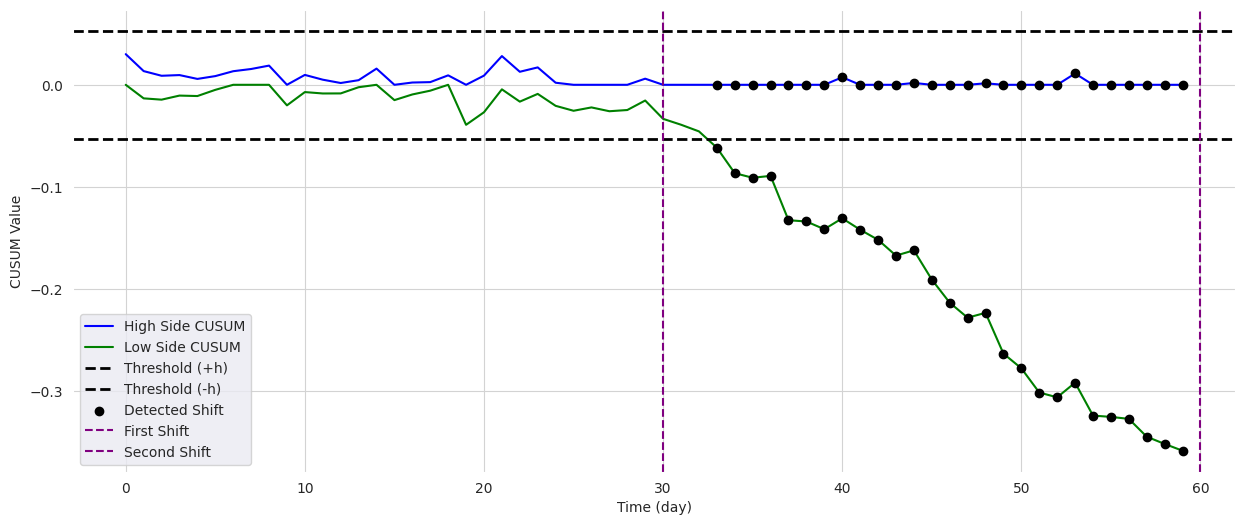

/home/kesavan.venkatesh/.conda/envs/P3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kesavan.venkatesh/.conda/envs/P3.8/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


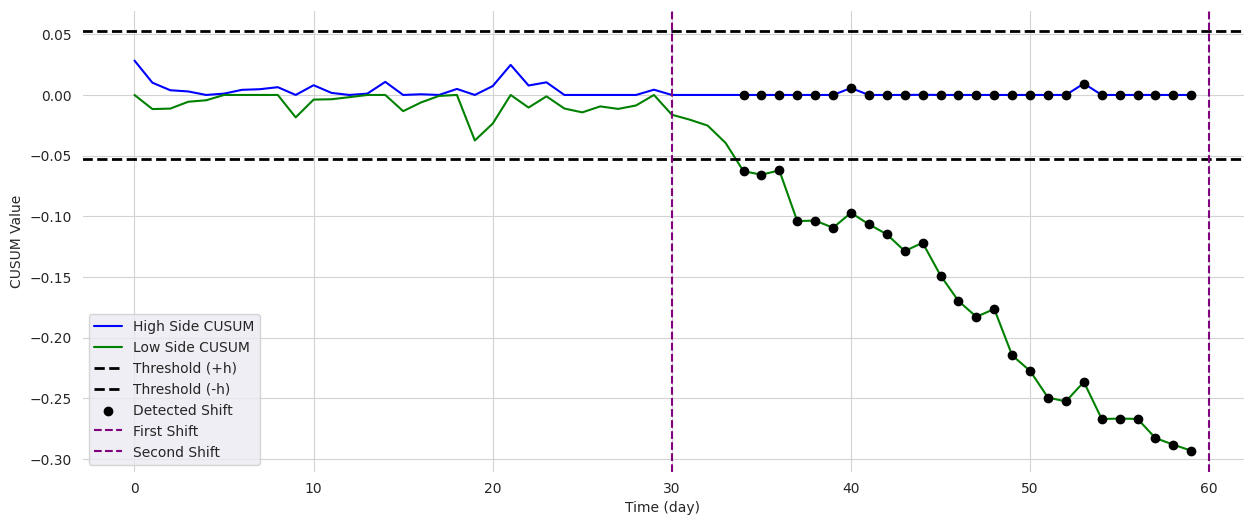

/home/kesavan.venkatesh/.conda/envs/P3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kesavan.venkatesh/.conda/envs/P3.8/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


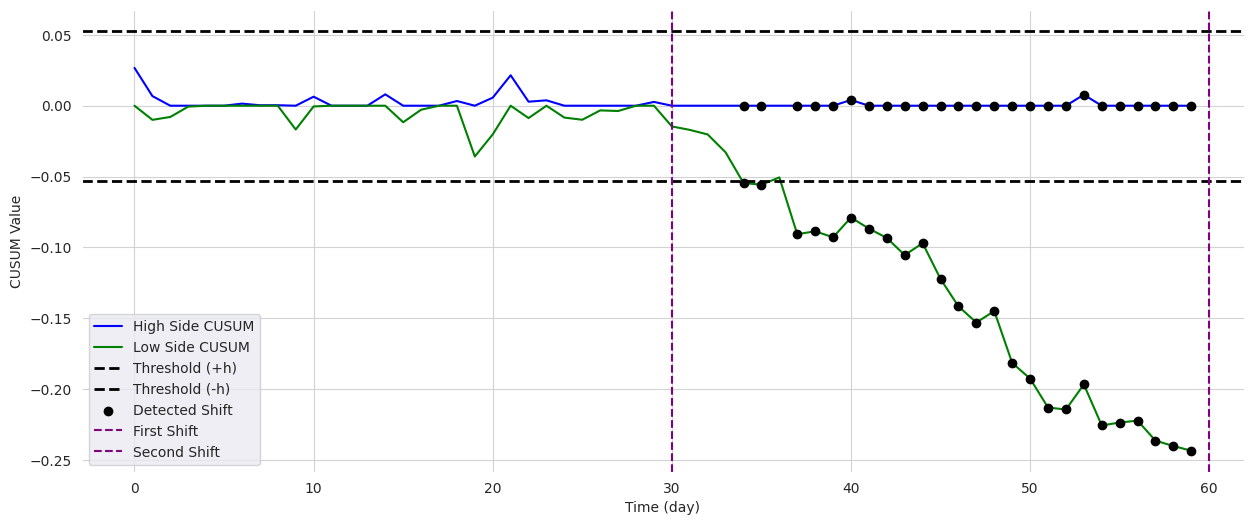

/home/kesavan.venkatesh/.conda/envs/P3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kesavan.venkatesh/.conda/envs/P3.8/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


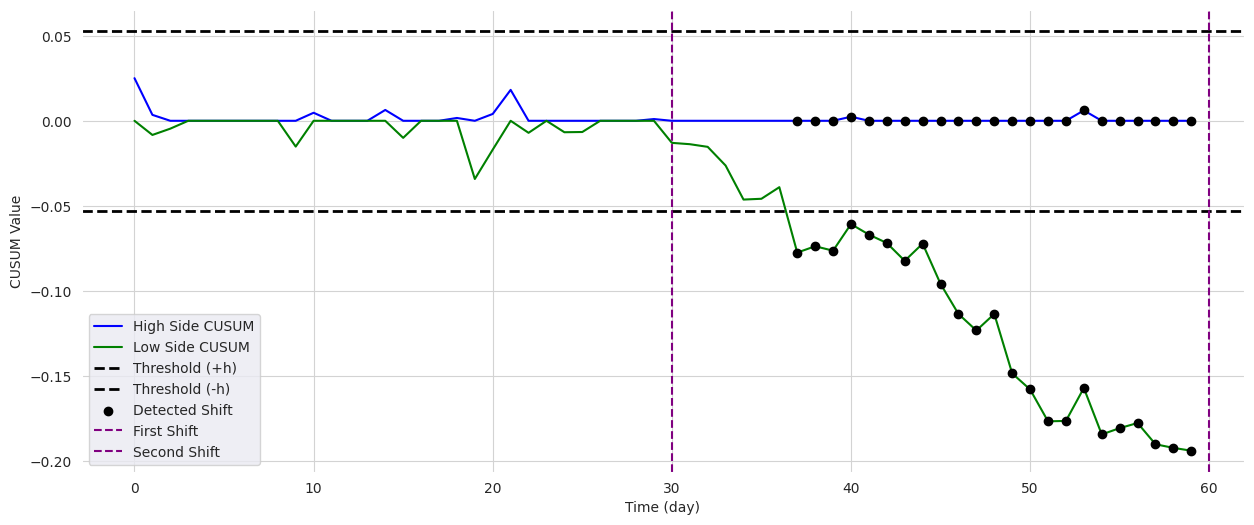

/home/kesavan.venkatesh/.conda/envs/P3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kesavan.venkatesh/.conda/envs/P3.8/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [15]:
ks = [0.1, 0.25, 0.5, 0.75, 1.0]
for k in ks:
    detector.changeDetection(CUSUM_data_average_day, pre_change_days, total_days, control_limit, k, save_plot=False)

 k value  Threshold  False Positives  True Positives  Average Detection Delay  MTBFA  False Alarm Rate
    0.10        4.0              0.0             0.0                      2.0    NaN               NaN
    0.25        4.0              0.0             0.0                      3.0    NaN               NaN
    0.50        4.0              0.0             0.0                      4.0    NaN               NaN
    0.75        4.0              0.0             0.0                      4.0    NaN               NaN
    1.00        4.0              0.0             0.0                      7.0    NaN               NaN


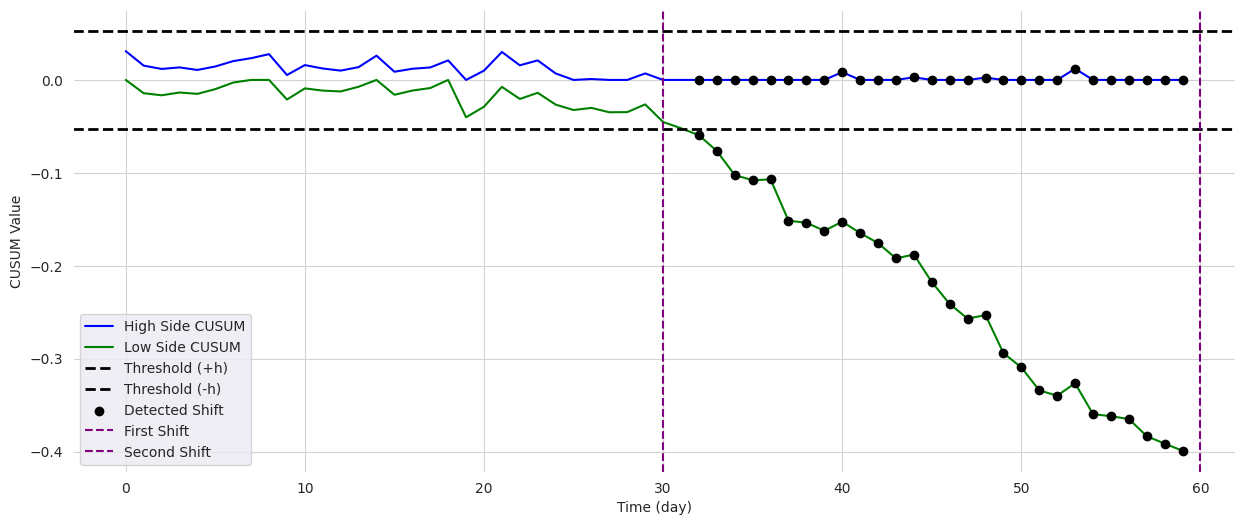

/home/kesavan.venkatesh/.conda/envs/P3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kesavan.venkatesh/.conda/envs/P3.8/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [16]:
# Choose best k
print(detector.summary())
# Save CUSUM for best k
detector.changeDetection(CUSUM_data_average_day, pre_change_days, total_days, control_limit, 0.10, save_plot=True)